# ResNet

In [1]:
# Importing needed libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Loading data
data_dir = '/content/drive/MyDrive/garbage/train'
test_dir = '/content/drive/MyDrive/garbage/test'

In [4]:
import os

data_root = "/content/drive/MyDrive/garbage"


for split in ['train', 'test']:
    split_path = os.path.join(data_root, split)

    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)

        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)

                try:
                    img_raw = tf.io.read_file(file_path)
                    img_tensor = tf.io.decode_image(img_raw, channels=3, expand_animations=False)

                except Exception as e:
                    os.remove(file_path)
                    print(f"🗑️ Deleted corrupted file: {file_path}")


In [5]:
# Splitting data
train_ds = tf.keras.preprocessing.image_dataset_from_directory (
    data_dir,
    subset = 'training',
    batch_size = 32,
    image_size = (180,180),
    shuffle = True,
    seed = 123,
    validation_split = 0.3,
    interpolation='nearest'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory (
    data_dir,
    subset = 'validation',
    batch_size = 32,
    image_size = (180,180),
    shuffle = False,
    seed = 123,
    validation_split = 0.3,
    interpolation='nearest'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory (
    test_dir,
    batch_size = 50,
    image_size = (180,180),
    shuffle = False,
    seed = 123,
    interpolation='nearest'
)

Found 17779 files belonging to 10 classes.
Using 12446 files for training.
Found 17779 files belonging to 10 classes.
Using 5333 files for validation.
Found 1980 files belonging to 10 classes.


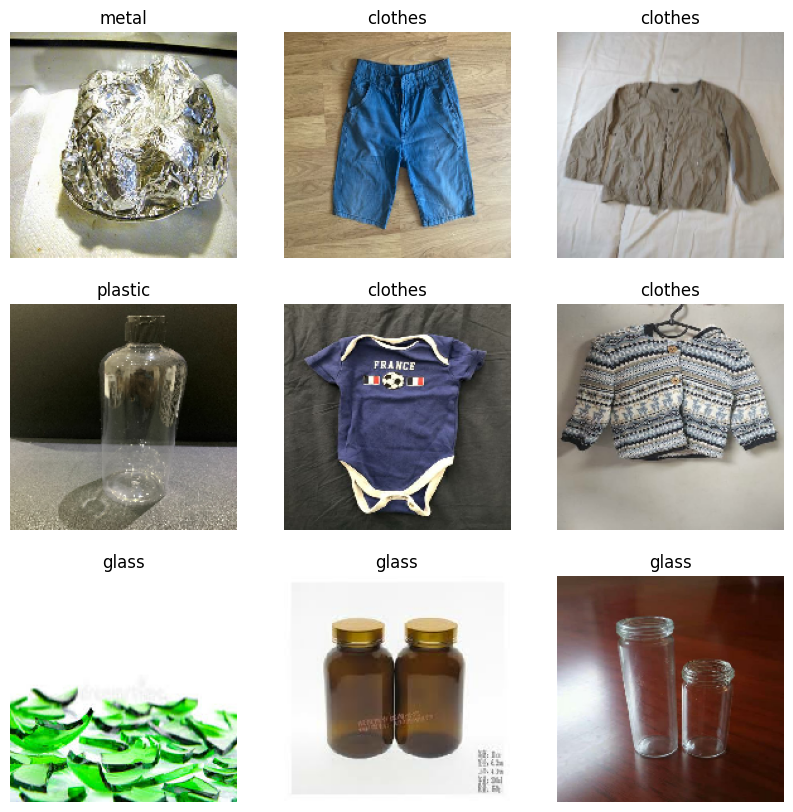

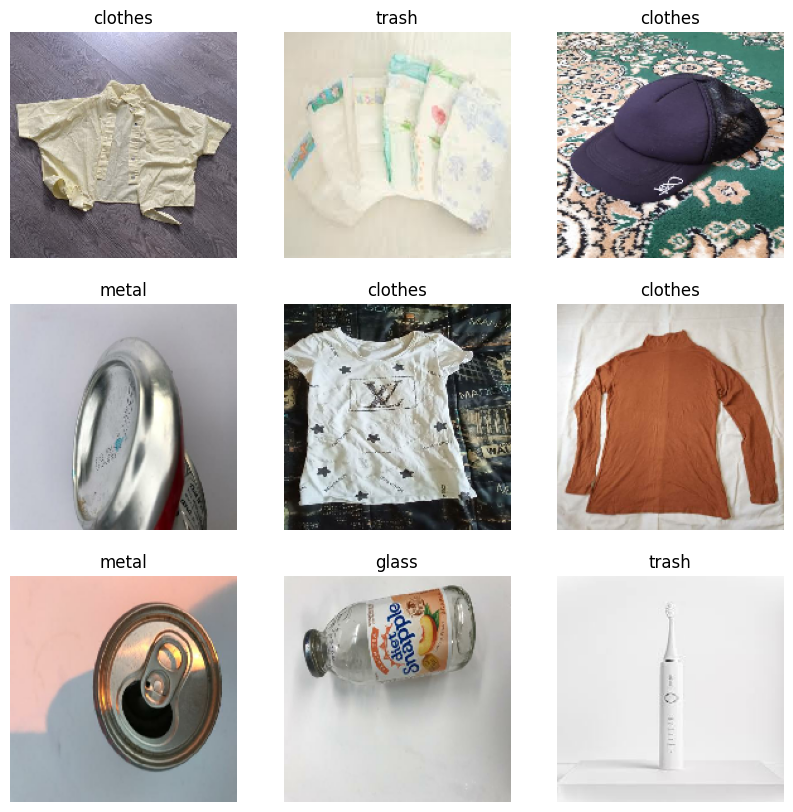

In [6]:
#visualising data
class_names = train_ds.class_names
for images, labels in train_ds.take(2):
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
# preprocessing

#normalization
normalization = tf.keras.layers.Rescaling(1.0/255)

train_ds = train_ds.map(lambda x, y: (normalization(x),y))
val_ds = val_ds.map(lambda x,y:(normalization(x),y))
test_ds = test_ds.map(lambda x,y:(normalization(x),y))

#augmentaion

augmentation = tf.keras.Sequential([
    # layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
    layers.RandomFlip('Horizental'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

train_ds = train_ds.map(lambda x,y: (augmentation(x, training=True),y))

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [8]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape = (180,180,3)
)

base_model.trainable = False

In [9]:
# Model construction and training

model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

In [ ]:
# model compilation and training
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 20
    )

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")